In [1]:
%load_ext autoreload
%autoreload 2
from proj1_helpers import *
from implementations import * 
from cross_validation import *

In [42]:
data_path = "data/train.csv"

In [43]:
y, x, ids = load_csv_data(data_path, sub_sample=False)

Accuracy of ridge_regression on the local test set : 0.7353
F1-score of ridge_regression on the local test set : 0.5138


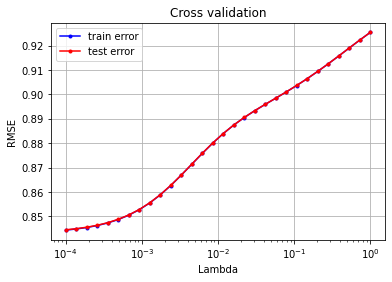

In [44]:
acc_local_test, f1_local, w_best = run_experiment(y, x, 'ridge_regression', 2323, 0.8)

In [126]:
test_path = 'data/test.csv'

y_test, x_test, ids_test = load_csv_data(test_path)
x_test, mean_x_test, std_x_test = standardize(x_test)
#y_test_pred = predict_labels_logistic_regression(w_cv, x_test)
y_test_pred = predict_labels(w_best, x_test)
create_csv_submission(ids_test, y_test_pred, 'ridge.csv')